# Writing Custom Loss Functions

Run this notebook on Google Colab:

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AG-Peter/encodermap/blob/main/tutorials/notebooks_customization/writing_custom_loss_functions.ipynb)

Find the documentation of EncoderMap:

https://ag-peter.github.io/encodermap

### For Google colab only:

If you're on Google colab, please uncomment these lines and install EncoderMap.

In [1]:
# !wget https://raw.githubusercontent.com/AG-Peter/encodermap/main/tutorials/install_encodermap_google_colab.sh
# !sudo bash install_encodermap_google_colab.sh

## Primer

In this tutorial we will learn how to write our own loss functions and add them to EncoderMap. Let us start with the imports:

In [2]:
import numpy as np
import encodermap as em
import pandas as pd
import tensorflow as tf

2023-02-07 11:14:31.849480: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2023-02-07 11:14:31.997359: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hostedtoolcache/Python/3.9.16/x64/lib
2023-02-07 11:14:31.997395: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2023-02-07 11:14:32.808582: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hostedtoolcache/Python/3.9.16/x64/lib
2023-02-07 11:14:32.808678: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hostedtoolcache/Python/3.9.16/x64/lib
2023-02-07 11:14:32.808689: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## Adding a unit circle loss

To show how to implement loss functions we will replace EncoderMap's center_cost with a loss that tries to push the low-dimensional points into a unit circle. For a unit circle the following equation holds true:

\begin{align}
x^2 + y^2 &= 1\\
x^2 + y^2 - 1 &= 0
\end{align}

Let us first plot a unit circle with matplotlib.

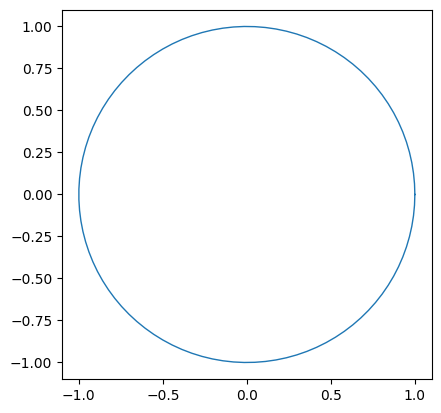

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

t = np.linspace(0,np.pi*2,100)

plt.close('all')
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.plot(np.cos(t), np.sin(t), linewidth=1)

**How to put this information into a loss function?**

We need to find a function that describes the distance between any (x, y)-coordinate to the unit circle.

In [4]:
def distance_to_unit_circle_2D(x, y):
    return np.abs((np.square(x) + np.square(y)) - 1)

def distance_to_unit_circle(points):
    return np.abs(np.sum(np.square(points), axis=0) - 1)

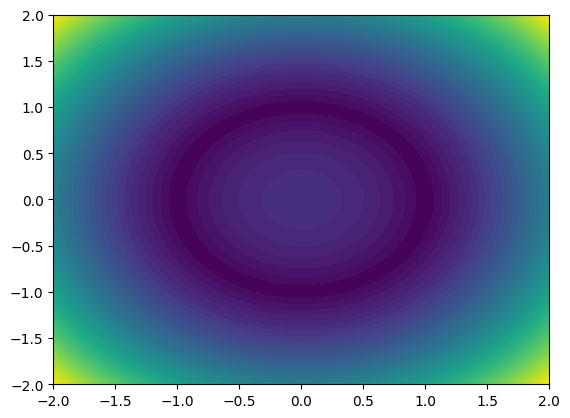

In [5]:
xx = np.linspace(-2, 2, 250)
yy = np.linspace(-2, 2, 250)
grid = np.meshgrid(xx, yy)
z = distance_to_unit_circle(grid)

plt.close('all')
plt.contourf(xx, yy, z, levels=60)

### Build a loss function from that:

Cost functions in EncoderMap are almost always closures. Meaning they return a function and not a value. Let's look at an example closure:

In [6]:
def print_msg(msg):
    # This is the outer enclosing function
    # The variable msg is part of the function's name space
    # This namespace is accesible by the nested function `printer`
    def printer():
        # This is the nested function
        print(msg)

    printer()

# We execute the function
# Output: Hello
print_msg("Hello")

Hello


The printer function was able to access the non-local variable `msg`. EncoderMap's loss functions use the non-local variables `model` and `parameters` (often abbreviated to `p`).

We will also add `tf.reduce_mean()` to get the mean distance from the unit circle for all points, because a loss is always a scalar value.

In [7]:
def circle_loss(model, parameters):
    """Circle loss outer function. Takes model and parameters. Parameters is only here for demonstration purpoes.
    It is not actually needed in the closure.
    
    """
    
    # use the models encoder part to create low-dimensional data
    latent = model.encoder
    
    def circle_loss_fn(y_true, y_pred=None):
        """Circle loss inner function. Takes y_true and y_pred. y_pred will not be used. y_true will be used to get
        the latent space of the autoencoder.
        
        """
        # get latent output
        lowd = latent(y_true)
        
        # get circle cost
        circle_cost = tf.reduce_mean(tf.abs(tf.reduce_sum(tf.square(lowd), axis=0) - 1))
        
        # bump up the cost to make it stronger than the other contributions
        circle_cost *= 5
        
        # write to tensorboard
        tf.summary.scalar('Circle Cost', circle_cost)
        
        # return circle cost
        return circle_cost
    
    # return inner function
    return circle_loss_fn

### Include the loss function in EncoderMap

**First:** Let us load the dihedral data from ../notebooks_easy and define some Parameters. For the parameters we will set the center_cost_scale to be 0 as to not interfere with our new circle cost.

In [8]:
df = pd.read_csv('/asp7.csv')
dihedrals = df.iloc[:,:-1].values.astype(np.float32)
cluster_ids = df.iloc[:,-1].values
print(dihedrals.shape, cluster_ids.shape)
print(df.shape)

FileNotFoundError: [Errno 2] No such file or directory: '/asp7.csv'

In [9]:
parameters = em.Parameters(
tensorboard=True,
center_cost_scale=0,
n_steps=100,
periodicity=2*np.pi,
main_path=em.misc.run_path('runs/custom_losses')
)

Now we can instaniate the `EncoderMap` class. For visualization purposes we will also make tensorboard write images.

In [10]:
e_map = em.EncoderMap(parameters, dihedrals)
e_map.add_images_to_tensorboard(dihedrals, image_step=1)

NameError: name 'dihedrals' is not defined

The loss is created by giving it the model and parameters of the parent `EncoderMap` instance. To not clash with the names of function and result we will call it `_circle_loss`.

In [11]:
circle_loss_fn = circle_loss(e_map.model, e_map.p)
print(_circle_loss)

NameError: name 'e_map' is not defined

Now we add this loss to `EncoderMap`'s losses

In [12]:
print(e_map.loss)
e_map.loss.append(_circle_loss)
print(e_map.loss)

NameError: name 'e_map' is not defined

### Train

Also make sure to execute tensorboard in the correct directory:

```bash
$ tensorboard --logdir . --reload_multifile True
```

If you're on Google colab, you can use tensorboard, by activating the tensorboard extension:

In [13]:
# %load_ext tensorboard
# %tensorboard --logdir .

In [14]:
e_map.train()

NameError: name 'e_map' is not defined

### Output

Here's what Tensorboard should put out:

<img src="custom_loss_functions_1.png" width="800">

## Conclusion

Using the closure method, you can easily add new loss functions to EncoderMap.